<h1><center>PISAP: Python Interactive Sparse Astronomical Data Analysis Packages</center></h1>
<h2><center>Anstronomic/Neuroimaging denoising tutorial</center></h2>
<div style="text-align: center">Credit: </div>

Pisap is a Python package related to sparsity and its application in
astronomical or mediacal data analysis. This package propose sparse denosing methods reusable in various contexts.
For more information please visit the project page on github: https://github.com/neurospin/pisap.<br><br>

<h3>First check</h3>

In order to test if the 'pisap' package is installed on your machine, you can check the package version:

In [1]:
import pisap
print pisap.__version__

/home/hc252523/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


0.0.0


<h2>The Condat-Vu primal dual sparse denoising with reweightings</h2>

The package provides a flexible implementation of the Condat-Vu denoising algorithm that can be reused is various contexts. In this tutorial we will apply this denoising method on two toy astronomical and neuroimaging toy dataset respectivelly.

<h3>Astronomical denoising</h3>

First load the toy datase and the associated sampling mask.

In [2]:
from pisap.data import get_sample_data

fits_data_path = get_sample_data("astro-fits")
image = pisap.io.load(fits_data_path)
image.show()
mask_data_path = get_sample_data("astro-mask")
mask = pisap.io.load(mask_data_path)
mask.show()

Now generate a synthetic image from the previous toy_dataset and sampling mask.

In [3]:
from pisap.base.utils import convert_mask_to_locations
from pisap.numerics.noise import add_noise
import scipy.fftpack as pfft

dirty_data = add_noise(image.data, sigma=0.05, noise_type="gauss")
dirty_image = pisap.Image(data=dirty_data)
dirty_image.show()
mask_shift = pfft.ifftshift(mask.data)
localization = convert_mask_to_locations(mask.data)
dirty_fft = mask_shift * pfft.fft2(dirty_image.data)

In [4]:
import data_provider
ref, loc, kspace = data_provider.load_m31_128_retrospection(sigma=0.25)

Now run the denoising algoritm with custom gradient and linear operator using a positivity constraint.

In [5]:
from pisap.numerics.reconstruct import sparse_rec_fista
from pisap.numerics.gradient import Grad2DSynthesis
from pisap.numerics.linear import Wavelet
from pisap.numerics.fourier import FFT
from pisap.numerics.cost import snr, nrmse

metrics = {'snr':{'metric':snr,
                  'mapping': {'x_new': 'test', 'y_new':None},
                  'cst_kwargs':{'ref':image.data},
                  'early_stopping': True,
                   },
            'nrmse':{'metric':nrmse,
                  'mapping': {'x_new': 'test', 'y_new':None},
                  'cst_kwargs':{'ref':image.data},
                  'early_stopping': False,
                   },
           }
params = {
    'data':kspace,
    'gradient_cls':Grad2DSynthesis,
    'gradient_kwargs':{"ft_cls": {FFT: {"samples_locations": loc,
                                        "img_size": kspace.shape[0]}}},
    'linear_cls':Wavelet,
    'linear_kwargs':{"nb_scale": 4, "wavelet": "MallatWaveletTransform79Filters"},
    'max_nb_of_iter':100,
    'mu':7.5e-3,
    'metrics':metrics,
    'verbose':1,
}

x, y, saved_metrics = sparse_rec_fista(**params)

x.show()
y.show()

Starting FISTA reconstruction algorithm.
 - mu:  0.0075
 - lipschitz_cst:  1.1
--------------------


 40% (40 of 100) |#########               | Elapsed Time: 0:00:14 ETA:  0:00:19

-------> early-stopping done


/home/hc252523/.local/lib/python2.7/site-packages/pyqtgraph/functions.py:1023: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.clip(data, 0, 255).astype(np.ubyte)


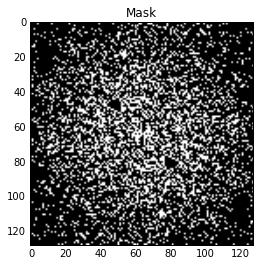

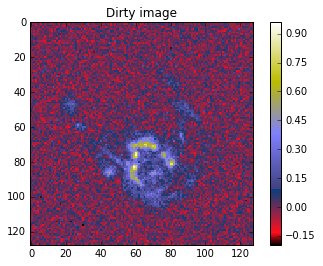

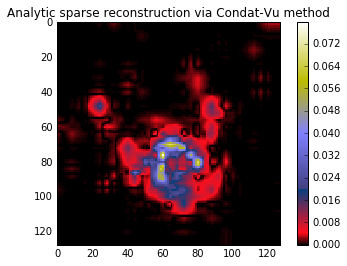

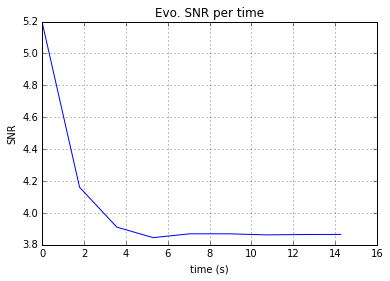

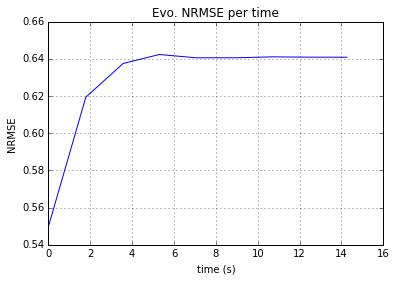

In [ ]:
import matplotlib.pylab as plt
import numpy

plt.figure()
plt.imshow(mask, cmap='gray')
plt.title("Mask")

plt.figure()
plt.imshow(dirty_image.data, interpolation="nearest", cmap="gist_stern")
plt.colorbar()
plt.title("Dirty image")

plt.figure()
plt.imshow(numpy.abs(x.data), interpolation="nearest", cmap="gist_stern")
plt.colorbar()
plt.title("Analytic sparse reconstruction via Condat-Vu method")

metric = saved_metrics['snr']
fig = plt.figure()
plt.grid()
plt.plot(metric['time'], metric['values'])
plt.xlabel("time (s)")
plt.ylabel("SNR")
plt.title("Evo. SNR per time")

metric = saved_metrics['nrmse']
fig = plt.figure()
plt.grid()
plt.plot(metric['time'], metric['values'])
plt.xlabel("time (s)")
plt.ylabel("NRMSE")
plt.title("Evo. NRMSE per time")

plt.show()

<h3>Neuroimagin denoising</h3>

First load the toy datase and the associated sampling mask.

In [ ]:
import scipy.fftpack as pfft
import pisap
from pisap.data import get_sample_data

fits_data_path = get_sample_data("mri-slice-nifti")
image = pisap.io.load(fits_data_path)
image.show()
mask_data_path = get_sample_data("mri-mask")
mask = pisap.io.load(mask_data_path)
mask.show()
mask_shift = pfft.ifftshift(mask.data)

Now generate a synthetic image from the previous toy_dataset and sampling mask.

In [ ]:
from sf_deconvolve.lib.noise import add_noise
import scipy.fftpack as pfft

dirty_data = add_noise(image.data, sigma=0.01, noise_type="gauss")
dirty_image = pisap.Image(data=dirty_data)
dirty_image.show()
dirty_fft = mask_shift * pfft.fft2(dirty_image.data)

In [ ]:
import data_provider
ref, loc, kspace = data_provider.load_phantom_512_retrospection(sigma=0.75)

Now run the denoising algoritm with custom gradient and linear operator using a positivity constraint.

In [ ]:
from pisap.numerics.reconstruct import sparse_rec_fista
from pisap.numerics.gradient import Grad2DSynthesis
from pisap.numerics.linear import Wavelet
from pisap.numerics.fourier import FFT
from pisap.numerics.cost import snr, nrmse

metrics = {'snr':{'metric':snr,
                  'mapping': {'x_new': 'test', 'y_new':None},
                  'cst_kwargs':{'ref':image.data},
                  'early_stopping': True,
                   },
            'nrmse':{'metric':nrmse,
                  'mapping': {'x_new': 'test', 'y_new':None},
                  'cst_kwargs':{'ref':image.data},
                  'early_stopping': False,
                   },
           }
params = {
    'data':kspace,
    'gradient_cls':Grad2DSynthesis,
    'gradient_kwargs':{"ft_cls": {FFT: {"samples_locations": loc,
                                        "img_size": kspace.shape[0]}}},
    'linear_cls':Wavelet,
    'linear_kwargs':{"nb_scale":3, "wavelet": "MallatWaveletTransform79Filters"},
    'max_nb_of_iter':100,
    'mu':1.0e-2,
    'metrics':metrics,
    'verbose':1,
}

x, y, saved_metrics = sparse_rec_fista(**params)

x.show()
y.show()

In [ ]:
import matplotlib.pylab as plt
import numpy

plt.figure()
plt.imshow(numpy.real(mask), cmap='gray')
plt.title("Mask")

plt.figure()
plt.imshow(dirty_image.data, interpolation="nearest", cmap="gist_stern")
plt.colorbar()
plt.title("Dirty image")

plt.figure()
plt.imshow(numpy.abs(x.data), interpolation="nearest", cmap="gist_stern")
plt.colorbar()
plt.title("Analytic sparse reconstruction via Condat-Vu method")

metric = saved_metrics['snr']
fig = plt.figure()
plt.grid()
plt.plot(metric['time'], metric['values'])
plt.xlabel("time (s)")
plt.ylabel("SNR")
plt.title("Evo. SNR per time")

metric = saved_metrics['nrmse']
fig = plt.figure()
plt.grid()
plt.plot(metric['time'], metric['values'])
plt.xlabel("time (s)")
plt.ylabel("NRMSE")
plt.title("Evo. NRMSE per time")

plt.show()